# 変化点検知入門

##  k-Nearest Neighbors

k- 近傍法を用いた、時系列データに対する変化点検知を行います。  

**使用するデータ**  
[data](data/qtdbsel.csv)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [10]:
df = pd.read_csv('data/qtdbsel.csv', header=None).rename(columns={0: 'value'})

In [11]:
df

,value
0,2.100
1,2.135
2,2.190
3,2.285
4,2.440
...,...
44995,5.070
44996,5.070
44997,5.085
44998,5.085


<AxesSubplot:>

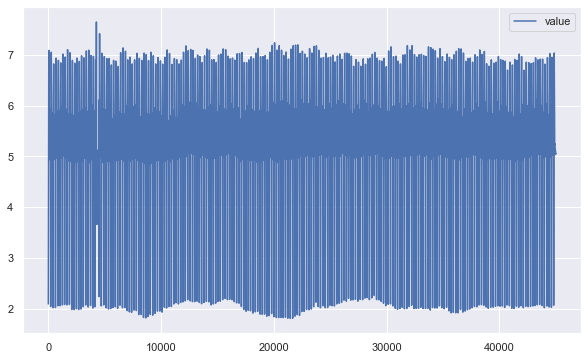

In [12]:
plt.rcParams['figure.figsize'] = (10, 6)
df.plot()

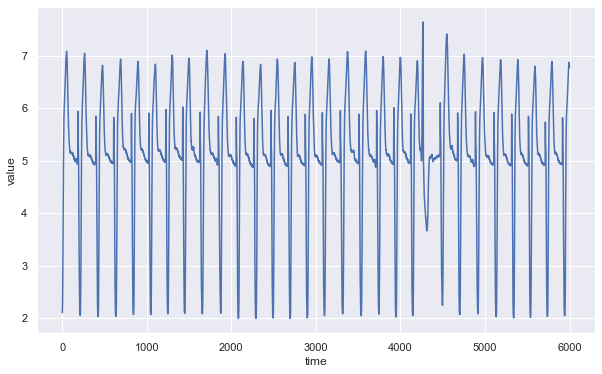

In [13]:
# 細かく可視化
plt.xlabel('time')
plt.ylabel('value')
plt.plot(df.loc[:6000], color='b')

距離ベースを使う場面では、全てのデータとの距離を計算することになるので正規化をおこない、データのスケールを整えることで計算量を減らす効果があります。

In [14]:
# データの前処理
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
norm_data = scaler.fit_transform(df)

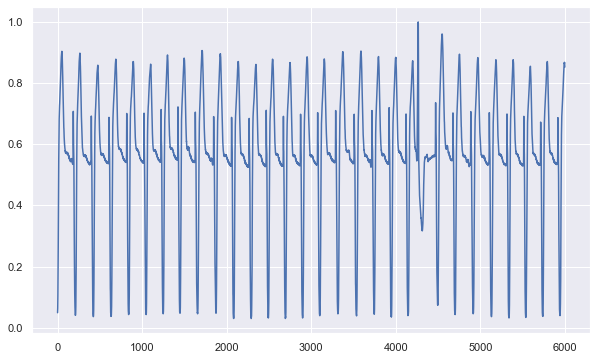

In [15]:
plt.plot(norm_data[:6000])

In [16]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2)
nbrs.fit(norm_data)

NearestNeighbors(n_neighbors=2)

In [17]:
distances, indices = nbrs.kneighbors(norm_data)

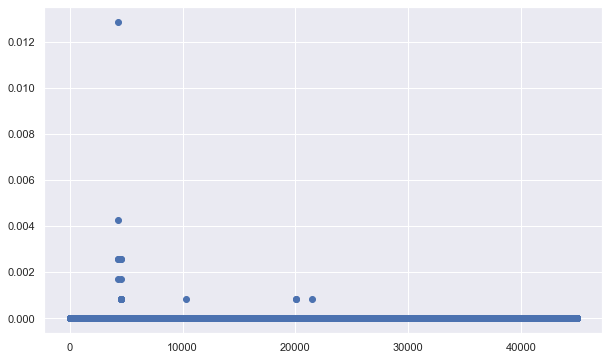

In [18]:
plt.scatter(range(len(distances)), distances[:, 1])

In [19]:
data = pd.DataFrame(norm_data, columns=['value'])
data['anomaly_score'] = distances[:, 1]
data

,value,anomaly_score
0,0.048885,0.0
1,0.054889,0.0
2,0.064322,0.0
3,0.080617,0.0
4,0.107204,0.0
...,...,...
44995,0.558319,0.0
44996,0.558319,0.0
44997,0.560892,0.0
44998,0.560892,0.0


In [20]:
# 異常判定
threshold = np.percentile(distances[:, 1], 99.5)
data['pred'] = data['anomaly_score'].map(lambda x: 1 if x>threshold else 0)
data

,value,anomaly_score,pred
0,0.048885,0.0,0
1,0.054889,0.0,0
2,0.064322,0.0,0
3,0.080617,0.0,0
4,0.107204,0.0,0
...,...,...,...
44995,0.558319,0.0,0
44996,0.558319,0.0,0
44997,0.560892,0.0,0
44998,0.560892,0.0,0


In [21]:
data[data['pred']==1].index

Int64Index([ 4263,  4264,  4265,  4266,  4267,  4541,  4542,  4544,  4549,
             4550,  4551,  4552,  4553,  4554, 10278, 20070, 20073, 21466],
           dtype='int64')

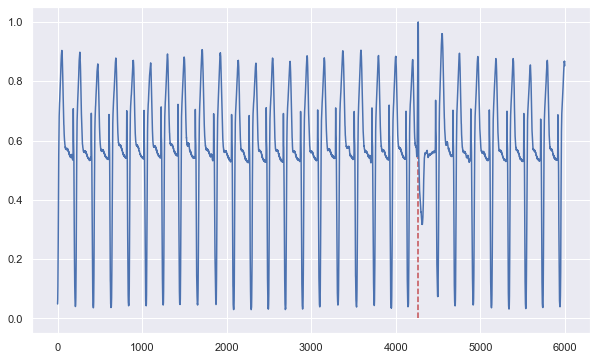

In [22]:
plt.plot(norm_data[:6000])
plt.vlines(x=4263, ymin=.0, ymax=1., colors='r', linestyles='--')

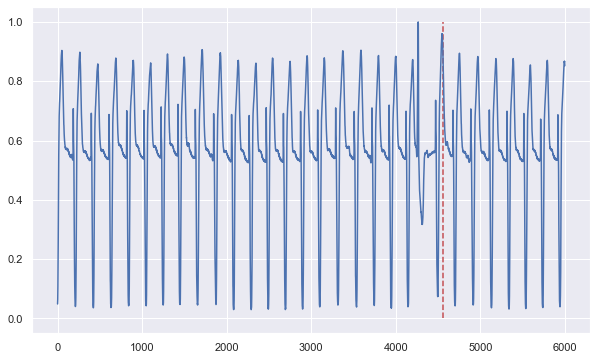

In [24]:
plt.plot(norm_data[:6000])
plt.vlines(x=4554, ymin=.0, ymax=1., colors='r', linestyles='--')

## Window 処理

変化検知において外れ値検出が有効でないとされるのは、時系列データをひとつひとつ独立なデータと見なし、時間的に近いデータの影響を無視することで継続的な異常を判別出来ないためです。そこで、時間的に近いデータをまとめて新たなデータを作ることでこの問題を解決します。  

まずは、サンプルデータを作成します。平均値と標準偏差を変えることでバラツキと位置を変えています。

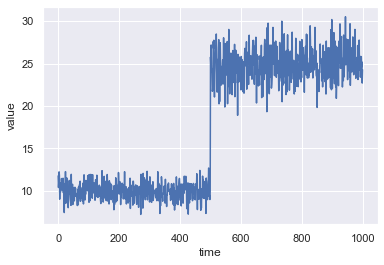

In [4]:
# データ準備
np.random.seed(0)

data1 = np.random.normal(10, 1, 500)
data2 = np.random.normal(25, 2, 500)
data = np.concatenate((data1, data2))

#可視化
plt.xlabel('time')
plt.ylabel('value')
plt.plot(data)

先程はうまくできていたように見えた K- 近傍法ですが、今回についても同様化を確認します。  

In [5]:
from sklearn.neighbors import NearestNeighbors
# モデルを定義
nbrs = NearestNeighbors(n_neighbors=2)
nbrs.fit(data.reshape(len(data), 1))

# 近傍距離を取得
distances, indices = nbrs.kneighbors(data.reshape(len(data), 1))

In [6]:
data = pd.DataFrame(data, columns=['value'])
data['anomaly_score'] = distances[:, 1]
# 閾値を設定
threshold = np.percentile(distances[:, 1], 99.5) # 99.5%
data['pred'] = data['anomaly_score'].map(lambda x: 1 if x>threshold else 0)
data

,value,anomaly_score,pred
0,11.764052,2.181815e-02,0
1,10.400157,1.110863e-03,0
2,10.978738,2.098948e-03,0
3,12.240893,1.583030e-02,0
4,11.867558,9.702766e-07,0
...,...,...,...
995,25.825742,8.896001e-03,0
996,24.603202,8.995888e-03,0
997,25.188385,4.258111e-03,0
998,22.704778,1.267884e-02,0


In [7]:
list(data[data['pred']==1].index)

[494, 589, 685, 943]

In [8]:
change_points = list(data[data['pred']==1].index)

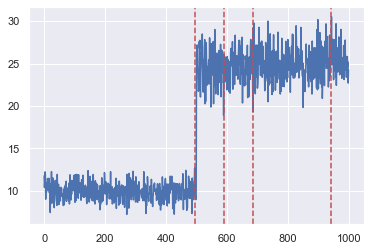

In [9]:
# 結果をプロット
plt.plot(data['value'])
for change_point in change_points:
  plt.axvline(x=change_point, color='r', linestyle='--')

検知した箇所が複数出てくるのは問題ではないですが、見たところ異常ではない箇所、変化の幅が小さいところも異常と検知しているので上手くいっていないことがわかります。

ここで、部分時系列を作成し、スライド窓の次元数の各点の差分を合計して異常度を再定義しましょう。単純に各点が独立しているのではなく、時系列も考慮して異常度を定義します。

### Window 処理（部分時系列処理）

各データから M 個の隣接した時系列データをまとめて、データを M 次元のベクトルの集まりにします。例えば M=5 のときの時系列データの変換を表しており、このときデータを纏めている曲線を長さ5の Window（スライド窓） といい、できた5次元ベクトルの集まりデータを 部分時系列 といいます。時系列データという名前ではありますが、ベクトル形式のデータであることに注意してください。

![07](img/04/07.png)

Window 幅 10 で横に 1 ずつズレていく部分時系列を作成しましょう。

データ数 1000 に対して、窓幅 10、横ズレ 1 の部分時系列を作成するとは、部分時系列のシェイプは データ数 - スライド窓幅 + 横ズレの幅 となるので、1000−10+1=991 ベクトルとなります。

In [25]:
# 部分時系列を作る関数
def subseq(data, window):
    sequence = np.zeros((len(data) - window + 1, window))
    data_x = data[:, 0]
    for i in range(len(data) - window + 1):
        sequence[i, :] = data_x[i: window+i]
    return sequence

In [26]:
# データ準備
np.random.seed(0)

data1 = np.random.normal(10, 1, 500)
data2 = np.random.normal(25, 2, 500)
data = np.concatenate((data1, data2))

# Window 処理
data = data.reshape(len(data), 1)
window = 10

partial_data = subseq(data, window)
partial_data.shape

(991, 10)

In [27]:
# 確認
df = pd.DataFrame(partial_data)
df

,0,1,2,3,4,5,6,7,8,9
0,11.764052,10.400157,10.978738,12.240893,11.867558,9.022722,10.950088,9.848643,9.896781,10.410599
1,10.400157,10.978738,12.240893,11.867558,9.022722,10.950088,9.848643,9.896781,10.410599,10.144044
2,10.978738,12.240893,11.867558,9.022722,10.950088,9.848643,9.896781,10.410599,10.144044,11.454274
3,12.240893,11.867558,9.022722,10.950088,9.848643,9.896781,10.410599,10.144044,11.454274,10.761038
4,11.867558,9.022722,10.950088,9.848643,9.896781,10.410599,10.144044,11.454274,10.761038,10.121675
...,...,...,...,...,...,...,...,...,...,...
986,24.188117,26.448737,27.770523,24.393803,25.882066,25.357586,23.401155,25.481575,25.578241,25.825742
987,26.448737,27.770523,24.393803,25.882066,25.357586,23.401155,25.481575,25.578241,25.825742,24.603202
988,27.770523,24.393803,25.882066,25.357586,23.401155,25.481575,25.578241,25.825742,24.603202,25.188385
989,24.393803,25.882066,25.357586,23.401155,25.481575,25.578241,25.825742,24.603202,25.188385,22.704778


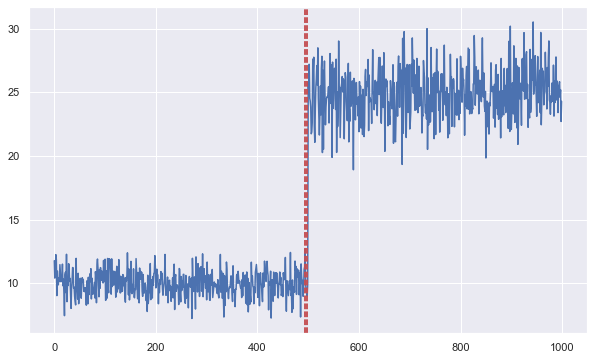

In [28]:
# k- 近傍法
nbrs = NearestNeighbors(n_neighbors=2)
nbrs.fit(partial_data)

distances, indices = nbrs.kneighbors(partial_data)

# 閾値を設定
threshold = np.percentile(distances[:, 1], 99.5) # 99.5%
# 変化点
change_points = indices[distances[:, 1] > threshold]

# 結果をプロット
plt.plot(data)
for change_point in change_points:
  plt.axvline(x=change_point[0], color='r', linestyle='--')

Window 幅を変えることで距離の値も変わってくるので、使用するデータの周期なども考慮しながら設定する必要があります。

## ChangeFinder

ChangeFinder とは自己回帰モデル（AR モデル）のオンライン忘却学習アルゴリズムである、SDAR アルゴリズム (Sequencially Discounting AR model learning) を活用したものです。  

今回内部の理論まで詳しくは扱いませんが、下記に簡単にアルゴリズムを整理しておきます。

1. SDAR で確率密度を学習（第一段階）
2. 各時点での変化点スコアを算出
3. 変化点スコアを平準化
4. SDAR で確率密度を学習（第二段階）
5. 各時点での変化点スコアを算出

In [30]:
!pip install -q changefinder

In [31]:
import changefinder

設定するパラメータ

- `r`：忘却パラメータ
- `order`：AR モデルの次数
- `smooth`：平滑化の範囲

In [32]:
cf = changefinder.ChangeFinder(r=0.01, order=1, smooth=5)
ret = []
for i in data:
    score = cf.update(i)
    ret.append(score)

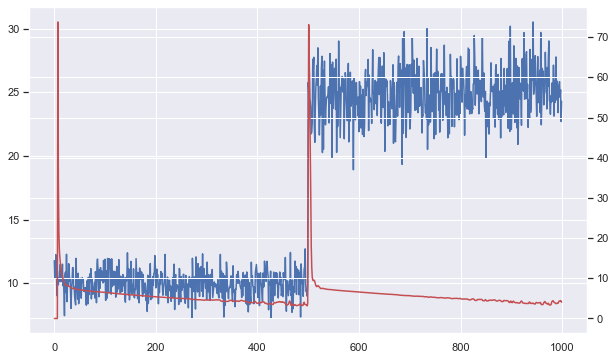

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(data)
ax2 = ax.twinx()
ax2.plot(ret,'r')
plt.show()

少しパラメータを変更してみましょう。   

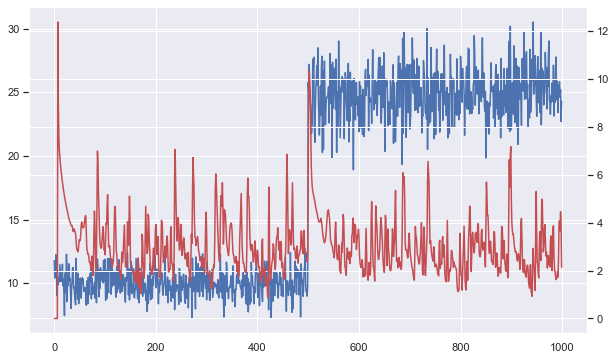

In [34]:
cf = changefinder.ChangeFinder(r=0.1, order=1, smooth=5)
ret = []
for i in data:
    score = cf.update(i)
    ret.append(score)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(data)
ax2 = ax.twinx()
ax2.plot(ret,'r')
plt.show()